In this notebook Felipe and Sara generate a stellar population using the stellar population synthesis code FSPS (Conroy et al. 2009; Conroy & Gunn 2010). We begin by generating an SED of a galaxy while only considering stellar population emission. We use a constant star formation rate of 5 $M_\odot$ per year, age 0.5 Gyr, and $z=3$. FSPS assumes a flat LCDM cosmological model with ($\Omega_{m}$, $\Omega_{\Lambda}$, $h$) = (0.26, 0.74, 0.72). We also insert IGM absorption according to Madau 1995, and a fixed metallicity of $Z[log(Z/Z_{\odot})] = 0.0190$ (Padova isochrones). Note that the metallicity equals $Z_{\odot}$. We also consider a small ISM dust absorption with dust attenuation applied equally to both old and new starlight. 

# Generate Stellar Population

In [1]:
%matplotlib inline
import fsps
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

First we generate the stellar population with the following parameters:

* add_igm_absorption: includes IGM absorption via Madau 1995
* zred: redshift
* zmet: metallicity integer that corresponds to a tabulated metallicity (see FSPS manual)
* sfh: star formation history. With sfh=3 we insert a table of (constant) star formation rates at time periods after the big bang.
* tage: Myr age
* dust_type: See Calzetti et al 2000. By setting this parameter to 2 dust attenuation is applied to all starlight equally (old and new). The ammount of attenuation is set by the dust_2 parameter.
* dust_2: small attenuation due to ISM dust. 

In [2]:
sp = fsps.StellarPopulation(add_igm_absorption=True, zred=3.,  zmet = 20., sfh=3, tage=0.5, 
                            dust1=0.0, dust2=0.1, dust_type=2 )

FSPS generates a population model that is normalized to $1M_{\odot}$ per year. Here we create arrays of age since big bang in Gyr and contant star formation rates of 5 solar mass / yr in order to scale the population.

In [3]:
a = np.arange(0.1, 0.6, 0.1)
sfr = np.full(5, 5.0)

Now we set the star formation history with a constant star formation rate.

In [4]:
sp.set_tabular_sfh(age = a, sfr = sfr)

# Print Flux in Desired Bands

Below we print the AB magnitudes in desired bands.

In [5]:
mags = sp.get_mags(zmet = 1., tage=0.5, bands=['wfc_acs_f435w', 'wfc_acs_f606w', 'wfc_acs_f775w', 'wfc_acs_f850lp', 'wfc3_ir_f105w', 'wfc3_ir_f125w', 'wfc3_ir_f160w', 'jwst_f200w', 'jwst_f277w', 'jwst_f356w', 'jwst_f444w'])
print 'HST F435W: ', mags[0]
print 'HST F606W: ', mags[1]
print 'HST F775W: ', mags[2]
print 'HST F850LP: ', mags[3]
print 'HST F105W: ', mags[4]
print 'HST F125W: ', mags[5]
print 'HST F160W: ', mags[6]
print 'JWST F200W: ', mags[7]
print 'JWST F277W: ', mags[8]
print 'JWST F356W: ', mags[9]
print 'JWST F444W: ', mags[10]

HST F435W:  25.685180586652734
HST F606W:  25.194646169018057
HST F775W:  25.245591101064576
HST F850LP:  25.313704531210405
HST F105W:  25.38336539406353
HST F125W:  25.46820026206371
HST F160W:  25.3068973512635
JWST F200W:  25.295006040237567
JWST F277W:  25.480190802455958
JWST F356W:  25.567011528475433
JWST F444W:  25.641540680718585


# Generate SED

Now we can construct the SED (only considering stellar emission). FSPS outputs a spectrum in $L_{\odot}/Hz$ vs wavelength in $\mathring A$. 

In [133]:
wave, spec = sp.get_spectrum(zmet = 1., tage = 0.5)

We will convert the spectrum to $\mu$Jy using the luminosity distance.

In [17]:
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
r=cosmo.luminosity_distance(3).to(u.m).value
print 'Luminosity distance (m):', r
cosmo.luminosity_distance(3)

Luminosity distance (m): 8.03485249278e+26


<Quantity 26039.18355256 Mpc>

In [135]:
spec = spec * (3.828E26) # L_sol/Hz to W/Hz
spec = spec / (1.0E-26) # W/Hz to Jy*m^2 (1 Jy = 10^-26 W/Hz/m^2)
spec = spec / (1.0E-6) # convert to microJy
spec = spec / (4*np.pi*(r**2)) # divide by surface area from galaxy Jy*m^2 to Jy

Below we show the stellar emission only SED in blue. The red line denotes the Lyman limit. This will be used to determine the lyman continuum photon rate, as these photons are only emitted at energies above the Lyman limit. 

In [136]:
lyman_lim=912. #angstroms

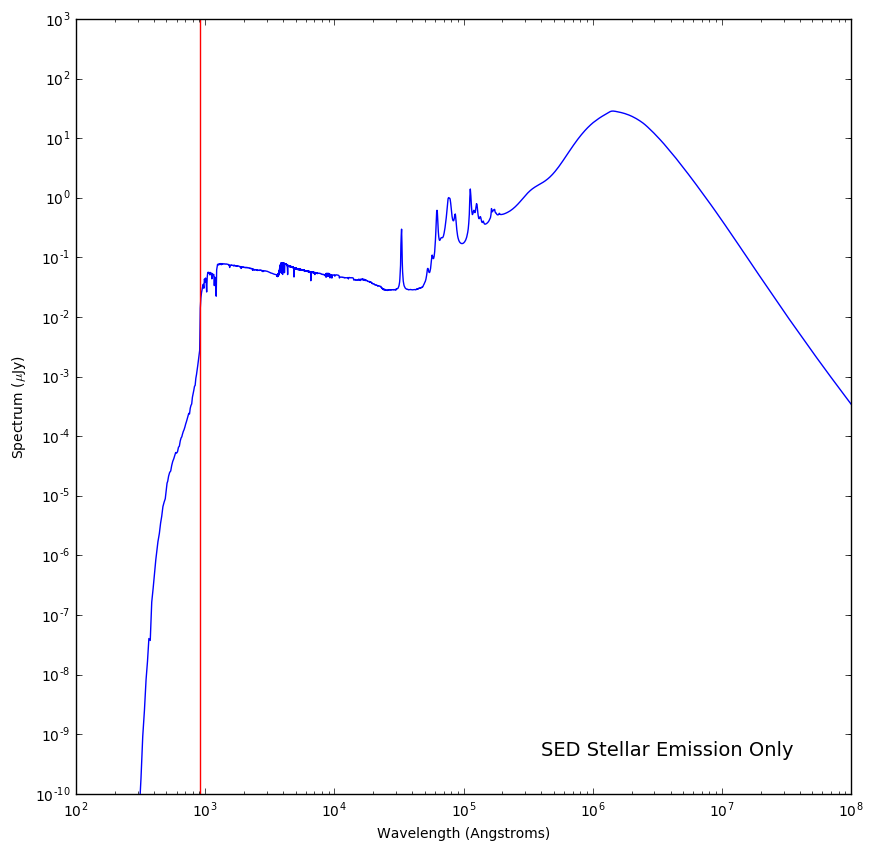

In [137]:
fig = plt.figure(figsize=[10,10])
plt.plot(wave, spec)
plt.axvline(lyman_lim, c='r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Spectrum ($\mu$Jy)')
plt.xlim(1e2,1e8)
plt.ylim(1e-10,1e3)
plt.annotate('SED Stellar Emission Only', xy=(0.6, 0.05), xycoords='axes fraction', fontsize = 14)

# Get Lyman continuum photon rate

Below we integrate the SED to determine the Lyman continuum photon count given SED energies above the Lyman limit.

In [138]:
from astropy.constants import h, c
print h
print c

  Name   = Planck constant
  Value  = 6.62606957e-34
  Uncertainty  = 2.9e-41
  Unit  = J s
  Reference = CODATA 2010
  Name   = Speed of light in vacuum
  Value  = 299792458.0
  Uncertainty  = 0.0
  Unit  = m / s
  Reference = CODATA 2010


In [9]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = (nodes - node)**2
    return np.argmin(dist_2)

In [140]:
wave, spec = sp.get_spectrum(zmet = 1., tage = 0.5, peraa=True)

In [141]:
spec = spec * (3.828E26) # L_sol/AA to W/AA (i.e. J/s/AA)
wave_m = wave * (1e-10) #Angstroms to meters
energies = (h.value*c.value)/wave_m #in J
photon_count_per_wavelength = spec / energies # 1/s/AA

In [142]:
wave[:closest_node(lyman_lim, wave)+1]

array([  91.,   94.,   96.,   98.,  100.,  102.,  104.,  106.,  108.,
        110.,  114.,  118.,  121.,  125.,  127.,  128.,  131.,  132.,
        134.,  137.,  140.,  143.,  147.,  151.,  155.,  159.,  162.,
        166.,  170.,  173.,  177.,  180.,  182.,  186.,  191.,  194.,
        198.,  202.,  205.,  210.,  216.,  220.,  223.,  227.,  230.,
        234.,  240.,  246.,  252.,  257.,  260.,  264.,  269.,  274.,
        279.,  284.,  290.,  296.,  301.,  308.,  318.,  328.,  338.,
        348.,  357.,  366.,  375.,  385.,  395.,  405.,  414.,  422.,
        430.,  441.,  451.,  460.,  470.,  480.,  490.,  500.,  506.,
        512.,  520.,  530.,  540.,  550.,  560.,  570.,  580.,  590.,
        600.,  610.,  620.,  630.,  640.,  650.,  658.,  665.,  675.,
        685.,  695.,  705.,  716.,  726.,  735.,  745.,  755.,  765.,
        775.,  785.,  795.,  805.,  815.,  825.,  835.,  845.,  855.,
        865.,  875.,  885.,  895.,  905.,  915.])

In [143]:
#integrate over Lyman wavelengths to get photon gocunt
photon_count = np.trapz(photon_count_per_wavelength[:closest_node(lyman_lim, wave)+1], 
                        wave[:closest_node(lyman_lim, wave)+1]) 

In [144]:
print 'Lyman continuum photon rate: ', photon_count, ' per second'

Lyman continuum photon count:  3.63601000181e+52


# Plot SEDs with photometric points 

Below we plot the transmission curves for the desired HST and JWST bands.

In [10]:
def get_filter_bounds(transmissions, wavelengths):
    length = len(transmissions)
    
    l_bound = closest_node(0.1, transmissions[:length/2])
    r_bound = closest_node(0.1, transmissions[length/2:])
    
    return wavelengths[l_bound], wavelengths[(length/2) + r_bound]


Text(0,0.5,u'Transmission')

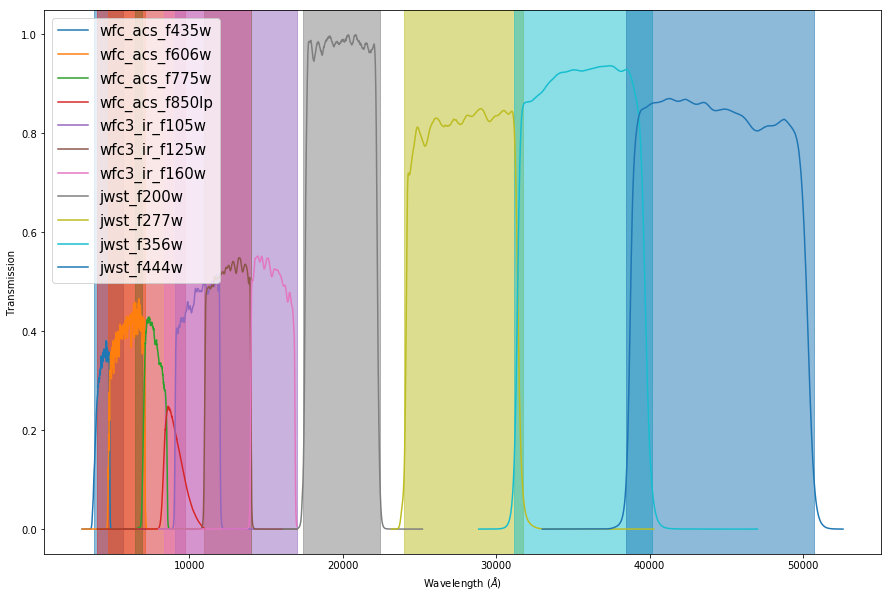

In [11]:
photometry_bands = ['wfc_acs_f435w','wfc_acs_f606w','wfc_acs_f775w','wfc_acs_f850lp','wfc3_ir_f105w','wfc3_ir_f125w',
             'wfc3_ir_f160w','jwst_f200w','jwst_f277w','jwst_f356w','jwst_f444w']
wavelengths =[]
transmissions = []
plt.figure(figsize=[15,10])
for band in photometry_bands:
    b = fsps.get_filter(band)
    wavelength,transmission = b.transmission
    
    wavelengths.append(wavelength)
    transmissions.append(transmission)
    
    p = plt.plot(wavelength,transmission,label=band)
        
    l_bound, r_bound = get_filter_bounds(transmission, wavelength)
    plt.axvspan(l_bound, r_bound, alpha=0.5, color= p[0].get_color())
    
    
plt.legend(loc='upper left', fontsize=15)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Transmission')    

In [19]:
wave, spec = sp.get_spectrum(zmet = 1., tage = 0.5)

In [20]:
spec = spec * (3.828E26) # L_sol/Hz to W/Hz
spec = spec / (1.0E-26) # W/Hz to Jy*m^2 (1 Jy = 10^-26 W/Hz/m^2)
spec = spec / (1.0E-6) # convert to microJy
spec = spec / (4*np.pi*(r**2)) # divide by surface area from galaxy Jy*m^2 to Jy

We also plot the spectrum with the desired bands.

(0.01, 2)

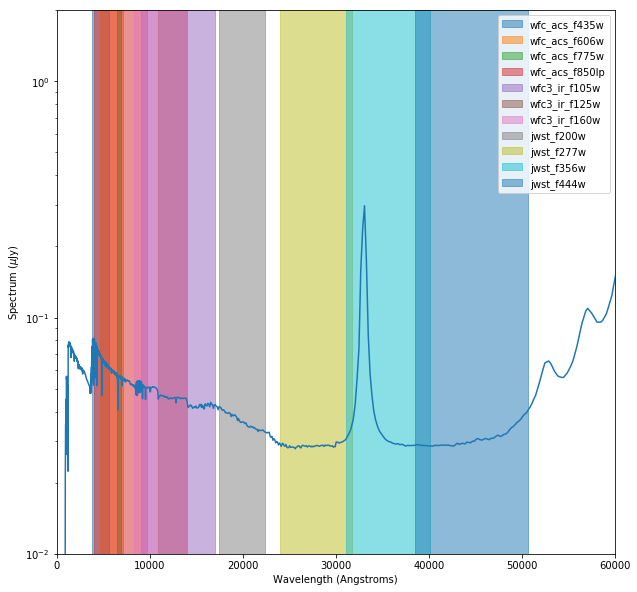

In [21]:
fig = plt.figure(figsize=[10,10])
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf','#1f77b4']

for i, band in enumerate(photometry_bands):
    b = fsps.get_filter(band)
    wavelength,transmission = b.transmission #angstroms
       
    l_bound, r_bound = get_filter_bounds(transmission, wavelength)
    plt.axvspan(l_bound, r_bound, alpha=0.5, color= new_colors[i], label=band)
    
plt.plot(wave, spec)
plt.legend()
plt.yscale('log')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Spectrum ($\mu$Jy)')
plt.xlim(0,6e4)
plt.ylim(1e-2,2)

HST bands have a lot of overlap. JWST bands do not.

# Getting photometry 

In [61]:
wave, spec = sp.get_spectrum(zmet = 1., tage = 0.5)

In [62]:
spec = spec * (3.828E26) # L_sol/Hz to W/Hz
spec = spec / (1.0E-26) # W/Hz to Jy*m^2 (1 Jy = 10^-26 W/Hz/m^2)
#spec = spec / (1.0E-6) # convert to microJy
spec = spec / (4*np.pi*(r**2)) # divide by surface area from galaxy Jy*m^2 to Jy

In [63]:
wavelength

array([33011., 33024., 33038., ..., 52590., 52603., 52617.])

In [64]:
transmission

array([1.006e-05, 1.078e-05, 1.057e-05, ..., 1.626e-05, 1.379e-05,
       1.142e-05])

In [65]:
transmission_sed = np.interp(wave,wavelength,transmission)
transmission_times_flux = transmission_sed * spec


(30000, 60000)

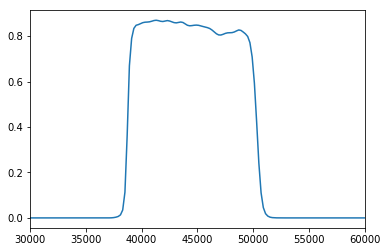

In [82]:
#plt.plot(wavelength,transmission)
plt.plot(wave,transmission_sed )
plt.xlim([30000,60000])

In [69]:
num = np.trapz(transmission_times_flux, wave)
den = np.trapz(transmission_sed, wave)

In [70]:
num/den

9.983644168406527e-08

In [71]:
-2.5*np.log10(num/den/3631.)

26.40184288796366

In [72]:
b.fullname

u'JWST F444W (http://www.stsci.edu/jwst/instruments/nircam/instrumentdesign/filters/)'

In [73]:
mags[-1]

25.641540680718585